In [4]:
import ee 
import requests  
import os

ee.Initialize()

In [3]:
import rasterio 
from pyproj import Transformer 
tif_path = '/mnt/data2tb/nsidc_images/NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20220117.tif'
with rasterio.open(tif_path) as src:
        print("Raster CRS:", src.crs)
        raster_crs = src.crs
        print("RASTER CRS:",raster_crs)
        # Because tiff file is in EPSG:6933, we need to transform the coordinates of points to the raster CRS
        transformer = Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True)

Raster CRS: LOCAL_CS["WGS 84 / NSIDC EASE-Grid 2.0 Global",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
RASTER CRS: LOCAL_CS["WGS 84 / NSIDC EASE-Grid 2.0 Global",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


ProjError: Error creating Transformer from CRS.

In [16]:
def export_image_to_drive(image, region, description, folder, scale, crs = 'EPSG:4326'):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        fileNamePrefix=description,
        region=region,
        scale=scale,
        crs=crs,
        fileFormat='GeoTIFF',
        maxPixels = 1e13
    )
    task.start()
    print(f"Export task started: {description} to folder {folder}")

roi = ee.FeatureCollection('projects/ee-lengocthanh/assets/vn4').geometry()

srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm).select(['elevation', 'slope', 'aspect']).toFloat()

image_id = 'DEM_Vietnam_4'
folder = 'GEE_Exports'
resolution = 30

export_image_to_drive(terrain, roi, image_id, folder, resolution)

Export task started: DEM_Vietnam_4 to folder GEE_Exports


In [9]:
sand = ee.Image("projects/soilgrids-isric/sand_mean").select('sand_0-5cm_mean')  # .select(sand);
clay = ee.Image("projects/soilgrids-isric/clay_mean").select('clay_0-5cm_mean')  # .select(clay);
bdod = ee.Image("projects/soilgrids-isric/bdod_mean").select('bdod_0-5cm_mean')  # .select(bdod);
soil_image = sand.addBands([clay, bdod])

image_id = 'SoilGrids_Vietnam'
resolution = 250

export_image_to_drive(soil_image, roi, image_id, folder, resolution)

Export task started: SoilGrids_Vietnam to folder GEE_Exports


In [16]:
locations = [{'name': 'trongcaycongnghiep', 'coords':[108.39025,13.13342]},
             {'name': 'dattrong', 'coords':[108.36543,13.07644]},
             {'name': 'suondoi', 'coords': [108.377571,13.175034]},
             {'name': 'caycongnghiep', 'coords': [108.379945,13.15427]},
             {'name': 'caycongnghiep2', 'coords': [108.371436,13.080238]},
             {'name': 'dancu', 'coords': [108.330109, 13,1149]}]

cuulong_locs = [{'name': 'cayanqua1', 'coords': [106.379153,10.471459]},
                {'name': 'cayanqua2', 'coords': [106.473187,10.502024]},
                {'name': 'lua1', 'coords': [106.52087,10.5408]},
                {'name': 'lua2', 'coords': [106.577586,10.508589]}]

binhthuan_locs = [{'name': 'trongcay1', 'coords': [107.841806,10.836219]},
                  {'name': 'trongcay2', 'coords': [107.707654,10.795740]},
                  {'name': 'trongcay3', 'coords': [107.898637,10.956097]},
                  {'name': 'rung1', 'coords': [107.81249,10.91406]},
                  {'name': 'rung2', 'coords': [107.6876,10.9969]}]

In [17]:
import ee
import pandas as pd
from datetime import datetime

# Initialize the Earth Engine module
ee.Initialize()

# === Define time range ===
start_date = '2021-01-01'
end_date = '2022-12-31'

# === Load SMAP L3 Soil Moisture dataset ===
# Load SMAP ImageCollection
smap = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005") \
    .filterDate(start_date, end_date) \
    .select(["soil_moisture_am", "soil_moisture_pm", "retrieval_qual_flag_am", "retrieval_qual_flag_pm"])

for loc in binhthuan_locs:
    name = loc["name"]
    point = ee.Geometry.Point([loc["coords"][0], loc["coords"][1]])
    feature = ee.Feature(point, {"name": name})
    fc = ee.FeatureCollection([feature])

    def process_image(image):
        date = image.date().format("YYYY-MM-dd")
        image = image.set("date", date)
        sampled = image.sampleRegions(
            collection=fc,
            scale=9000,
            geometries=True
        )
        return sampled.map(lambda f: f.set("date", date))

    sampled = smap.map(process_image).flatten()

    data = sampled.getInfo()["features"]
    records = []
    for f in data:
        p = f["properties"]
        coords = f["geometry"]["coordinates"]
        am = p.get("soil_moisture_am", None)
        pm = p.get("soil_moisture_pm", None)
        qual_flag_am = p.get("retrieval_qual_flag_am", None)
        qual_flag_pm = p.get("retrieval_qual_flag_pm", None)
        sm = None

        if am is not None and pm is not None: 
            sm = 0.5 * (am + pm)
        # if qual_flag_am == 1 or qual_flag_pm == 1:
        #     print("The sm is not reliable")
        # if qual_flag_am == 0 and qual_flag_pm == 0 and am is not None and pm is not None:
        #     sm = 0.5 * (am + pm)
            
        records.append({
            "location": name,
            "lon": coords[0],
            "lat": coords[1],
            "date": p["date"],
            "soil_moisture_am": am,
            "soil_moisture_pm": pm,
            "sm": sm
        })

    df = pd.DataFrame(records)
    os.makedirs("roi_inference/binhthuan/point_sm/smap", exist_ok = True)
    df.to_csv(f"roi_inference/binhthuan/point_sm/smap/{name}.csv", index=False)
    print("✅ Soil moisture data saved to 'smap_soil_moisture_2021_2022.csv'")


✅ Soil moisture data saved to 'smap_soil_moisture_2021_2022.csv'
✅ Soil moisture data saved to 'smap_soil_moisture_2021_2022.csv'
✅ Soil moisture data saved to 'smap_soil_moisture_2021_2022.csv'
✅ Soil moisture data saved to 'smap_soil_moisture_2021_2022.csv'
✅ Soil moisture data saved to 'smap_soil_moisture_2021_2022.csv'


In [19]:
import os 
import rasterio
import pandas as pd 
import re 
from rasterio.transform import from_origin
from datetime import datetime

def convert_date(date_str):
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    return date_obj.strftime('%Y-%m-%d')

def extract_date(filename):
    date_parttern = r'(\d{4}-\d{2}-\d{2})'
    matching = re.search(date_parttern, filename)
    if matching:
        return matching.group(1)
    else:
        return None
    
def get_soil_moisture_at_point(tif_file, point):
    with rasterio.open(tif_file) as src:
        row, col = src.index(point[0], point[1]) # point is (longitude, latitude)
        sm = src.read(2)[row, col]
        
        if sm != None:
            return sm 
        else:
            return None

# Paths to the folder containing TIFF files and the output CSV file
tif_folder = 'roi_inference/binhthuan/sm'
output_csv = 'roi_inference/binhthuan/point_sm/pred'
os.makedirs(output_csv, exist_ok=True)

# Loop through each point
for point in binhthuan_locs:
    # Prepare a list to store the data for the current point
    data = []
    coords = point['coords']  # Get the coordinates for the point

    # Loop through each TIFF file in the folder
    for tif_file in os.listdir(tif_folder):
        if tif_file.endswith('.tif'):
            # Extract the date from the filename
            date = extract_date(tif_file)
            if date:
                # Get soil moisture value for the current point
                soil_moisture_value = get_soil_moisture_at_point(os.path.join(tif_folder, tif_file), coords)
                data.append({'Date': date, 'Name': point['name'], 'Longitude': coords[0], 'Latitude': coords[1], 'sm': soil_moisture_value})

    # Create a DataFrame and save it to a CSV file for the current point
    df = pd.DataFrame(data)
    point_csv_name = f"{point['name']}.csv"  # Naming the file based on the point name
    df.to_csv(os.path.join(output_csv, point_csv_name), index=False)

    print(f'Soil moisture data for point {point["name"]} saved to {point_csv_name}')

Soil moisture data for point trongcay1 saved to trongcay1.csv
Soil moisture data for point trongcay2 saved to trongcay2.csv
Soil moisture data for point trongcay3 saved to trongcay3.csv
Soil moisture data for point rung1 saved to rung1.csv
Soil moisture data for point rung2 saved to rung2.csv


(0.0, 0.6)

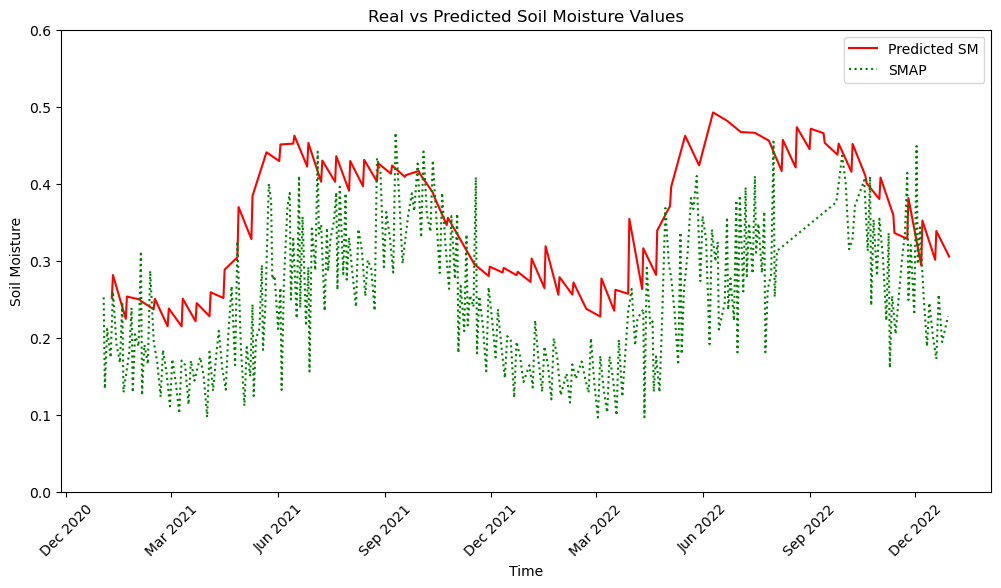

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def normalizingData(X, min_per, max_per):
    temp=(X - min_per) / (max_per - min_per)
    temp[temp>1]=1
    temp[temp<0]=0
    return temp

# Load real and predicted values
predicted = pd.read_csv('roi_inference/binhthuan/point_sm/pred/rung1.csv')
predicted = predicted.dropna(subset='sm')
gt = pd.read_csv('100m_data/output_tb/output_ndvi250_first/THAIBINH_130.csv')
smap = pd.read_csv('roi_inference/binhthuan/point_sm/smap/rung1.csv')
# Extract real and predicted values
predicted = predicted.sort_values('Date')
real_values = gt['sm_25'] if 'sm_25' in gt.columns else None
date_list = pd.to_datetime(predicted['Date']).to_list()

predicted_values = predicted['sm'].to_list()
smap_values = smap['sm'] if 'sm' in smap.columns else None 
smap_dates = smap['date'] if 'date' in smap.columns else None 
smap_dates = pd.to_datetime(smap_dates).to_list()

# Create a point plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(date_list, predicted_values, color='red', alpha=1.0, label = 'Predicted SM')
ax.plot(smap_dates, smap_values, color = 'green', alpha=1.0, linestyle = ':', label = 'SMAP')

# Format x-axis as dates 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation = 45)

plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Real vs Predicted Soil Moisture Values')
plt.legend()
plt.ylim(0.0, 0.6)

In [5]:
import pandas as pd 

smap = pd.read_csv('/mnt/data2tb/Transfer-DenseSM-E_2/100m_data/output_tb/tb_merged.csv')
print(smap.columns)
max(smap['sm_25'])

Index(['s_index', 'network', 'station', 'platform', 'orbit', 'date', 'VV',
       'VH', 'angle', 'DOY_sin',
       ...
       '143', '144', '145', '146', '147', '148', '149', '150', '151', '152'],
      dtype='object', length=165)


0.567